In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from torch.utils.data import DataLoader, TensorDataset
import time


In [2]:
# Convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.fillna(0, inplace=True)
    return agg

In [3]:
# Load and preprocess the data
file_path = "/home/shreevidyag/workspace/Data_bengaluru/combined_cleaned.csv"
data = pd.read_csv(file_path)
data.head()
data.loc[:, 'PM25'] = data['PM25'].fillna(0)
data = data[24:]
data.to_csv('pollution1.csv')
dataset = pd.read_csv('pollution1.csv', header=0, index_col=0)
values = dataset.values
values = values.astype('float32')

In [4]:
# Normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
reframed = series_to_supervised(values, 1, 1, True)
scaled_features = scaler.fit_transform(reframed.values[:, :-1])
scaled_label = scaler.fit_transform(reframed.values[:, -1].reshape(-1, 1))
values = np.column_stack((scaled_features, scaled_label))


In [5]:
# Split into train and test sets
n_train_hours = 60000
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]


In [6]:
# Split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

In [7]:
# Convert into PyTorch tensors
train_X = torch.tensor(train_X, dtype=torch.float32)
train_y = torch.tensor(train_y, dtype=torch.float32)
test_X = torch.tensor(test_X, dtype=torch.float32)
test_y = torch.tensor(test_y, dtype=torch.float32)

In [8]:
# Reshape input to be 3D [samples, timesteps, features]
train_X = train_X.unsqueeze(1)  # Add a dimension for timestep (1 time step)
test_X = test_X.unsqueeze(1)    # Add a dimension for timestep (1 time step)


In [9]:
# Define the model (Bidirectional LSTM with attention layer)
class BiLSTMWithAttention(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(BiLSTMWithAttention, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True, bidirectional=True)
        self.attn = nn.MultiheadAttention(embed_dim=hidden_size * 2, num_heads=1, batch_first=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)
        
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        attn_out, _ = self.attn(lstm_out, lstm_out, lstm_out)
        output = self.fc(attn_out[:, -1, :])  # Take the last time step output
        return output

In [10]:
# Initialize the model
model = BiLSTMWithAttention(input_size=train_X.shape[2], hidden_size=128, output_size=1)


In [11]:
# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [12]:
# Training loop
start = time.time()
epochs = 100
batch_size = 72

In [13]:
# Create DataLoader for train and test
train_dataset = TensorDataset(train_X, train_y)
test_dataset = TensorDataset(test_X, test_y)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [14]:
# Training phase
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    # Validation phase
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            val_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(train_loader)}, Val Loss: {val_loss/len(test_loader)}")


Epoch 1/100, Train Loss: 0.024926051672078033, Val Loss: 0.03500987941753437
Epoch 2/100, Train Loss: 0.019945027743564887, Val Loss: 0.06523936977582284
Epoch 3/100, Train Loss: 0.019856068064312695, Val Loss: 0.05023789235569709
Epoch 4/100, Train Loss: 0.019149791703164287, Val Loss: 0.04570414375941754
Epoch 5/100, Train Loss: 0.01846453970883057, Val Loss: 0.07003069186587176
Epoch 6/100, Train Loss: 0.018035968254894792, Val Loss: 0.05533377207303647
Epoch 7/100, Train Loss: 0.01770523997796384, Val Loss: 0.05336205798691359
Epoch 8/100, Train Loss: 0.018001600783010142, Val Loss: 0.03686866442530836
Epoch 9/100, Train Loss: 0.01743345454758719, Val Loss: 0.050279358679493624
Epoch 10/100, Train Loss: 0.017299937432202202, Val Loss: 0.04047215041399736
Epoch 11/100, Train Loss: 0.016965839537938194, Val Loss: 0.026579134886636855
Epoch 12/100, Train Loss: 0.016871300287776024, Val Loss: 0.03638977708832645
Epoch 13/100, Train Loss: 0.016557623973742396, Val Loss: 0.03926809848459

In [15]:
# Prediction phase
#model.eval()
#yhat = model(test_X)
#yhat = yhat.squeeze().detach().numpy()

In [16]:
# Evaluate the model
model.eval()
test_yhat = []
with torch.no_grad():
    for batch_X, _ in test_loader:
        yhat = model(batch_X)
        test_yhat.append(yhat)
test_yhat = torch.cat(test_yhat, dim=0).numpy()

In [17]:
# Invert scaling for forecast
#inv_yhat = np.column_stack((yhat, test_X[:, 1:].numpy()))  # Use numpy() here to convert tensor to numpy
#inv_yhat = scaler.inverse_transform(inv_yhat)
#inv_yhat = inv_yhat[:, 0]

In [18]:
# Inverse scaling
# Flatten test_X for compatibility with scaler.inverse_transform()
test_X_reshaped = test_X.reshape(test_X.shape[0], -1)

In [19]:
# Concatenate predictions with other features for inverse transform
inv_yhat = np.column_stack((test_yhat, test_X_reshaped[:, 1:]))
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, 0]  # Extract predictions


In [20]:
# Inverse transform true values
inv_y = np.column_stack((test_y.reshape(-1, 1), test_X_reshaped[:, 1:]))
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, 0]  # Extract true values


In [21]:
# Invert scaling for actual
#test_y = test_y.numpy().reshape(-1, 1)
#inv_y = np.column_stack((test_y, test_X[:, 1:].numpy()))  # Use numpy() here to convert tensor to numpy
#inv_y = scaler.inverse_transform(inv_y)
#inv_y = inv_y[:, 0]

#end = time.time()
#print(f'This took {end - start} seconds.')


In [22]:
# Calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse) 
# Calculate R^2
r2 = r2_score(inv_y, inv_yhat)
print(f'Variance score: {r2:.2f}')



Test RMSE: 54.778
Variance score: 0.50


In [23]:
# Pearson correlation
corr, _ = pearsonr(inv_y, inv_yhat)
print(f'Pearson correlation: {corr:.3f}')

Pearson correlation: 0.809


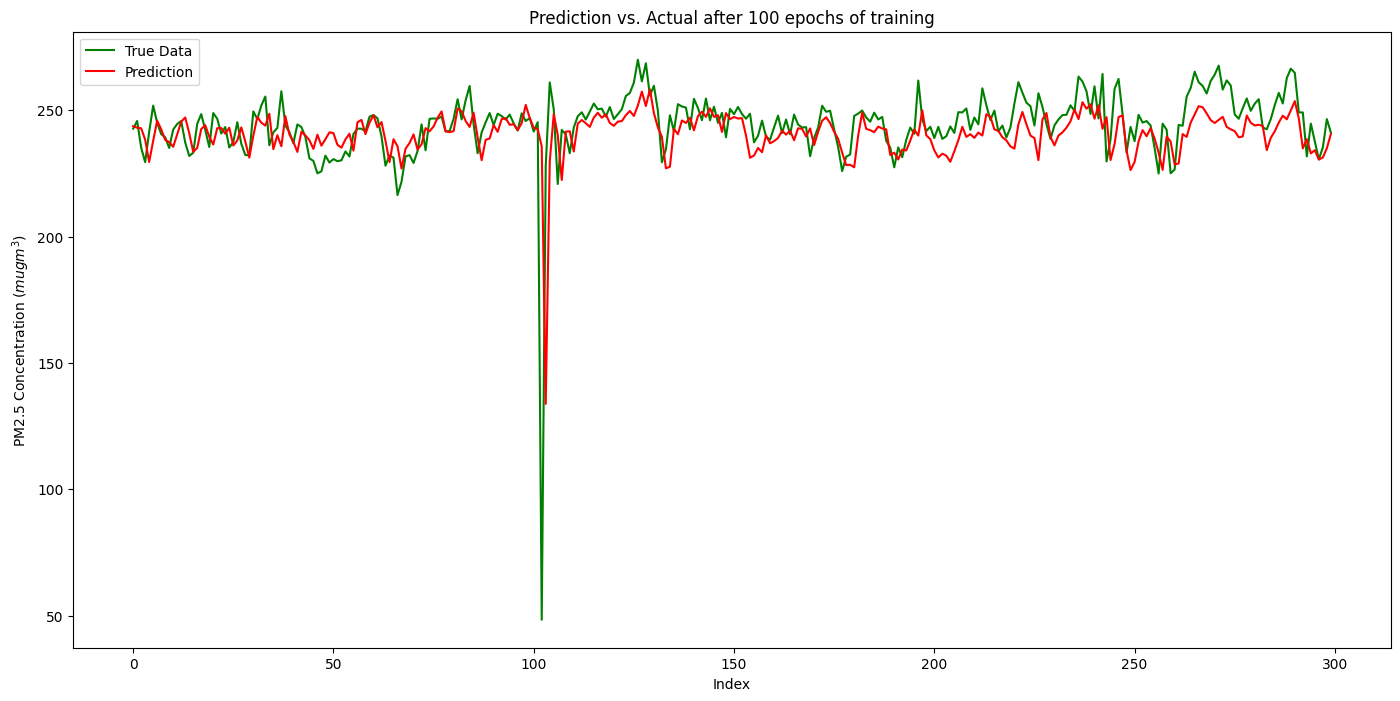

In [24]:
# Plot the results
def plot_predicted(predicted_data, true_data):
    plt.figure(figsize=(17, 8))
    plt.title('Prediction vs. Actual after 100 epochs of training')
    plt.plot(true_data, label='True Data', color='green')
    plt.plot(predicted_data, label='Prediction', color='red')
    plt.xlabel('Index')
    plt.ylabel('PM2.5 Concentration $(mu g  m^3)$')
    plt.legend()
    plt.savefig("lstm_pytorch.pdf")
    plt.show()

# Call the plot function with predicted vs true data
plot_predicted(inv_yhat[400:700], inv_y[400:700])
